In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time
from networkx.algorithms.community import greedy_modularity_communities
import random
import os

import gdown

In [2]:
url = 'https://drive.google.com/drive/folders/1lUOJw9b2VNcsR2WDG7X8zFqz1th-gYzC?usp=sharing'

if not os.path.exists('Data') or not os.listdir('Data'):
    gdown.download_folder(url, quiet=False)

In [3]:
file_path = os.path.join('Data', 'Airports2.csv')

# Read the CSV into a DataFrame
flight_network = pd.read_csv(file_path)

In [4]:

print(flight_network.head())


  Origin_airport Destination_airport    Origin_city Destination_city  \
0            MHK                 AMW  Manhattan, KS         Ames, IA   
1            EUG                 RDM     Eugene, OR         Bend, OR   
2            EUG                 RDM     Eugene, OR         Bend, OR   
3            EUG                 RDM     Eugene, OR         Bend, OR   
4            MFR                 RDM    Medford, OR         Bend, OR   

   Passengers  Seats  Flights  Distance    Fly_date  Origin_population  \
0          21     30        1       254  2008-10-01             122049   
1          41    396       22       103  1990-11-01             284093   
2          88    342       19       103  1990-12-01             284093   
3          11     72        4       103  1990-10-01             284093   
4           0     18        1       156  1990-02-01             147300   

   Destination_population  Org_airport_lat  Org_airport_long  \
0                   86219        39.140999        -96.6707


In this part we clean the dataset before creating graph from it: we remove the missing NAN values, normalise the airport codes and we put them all in capital letters.


In [5]:
flight_network.dropna(subset=['Origin_airport', 'Destination_airport'], inplace=True)


In [6]:
flight_network = flight_network[
    (flight_network['Origin_airport'].str.strip() != '') &
    (flight_network['Destination_airport'].str.strip() != '')
]


In [7]:
flight_network['Origin_airport'] = flight_network['Origin_airport'].str.upper().str.strip()
flight_network['Destination_airport'] = flight_network['Destination_airport'].str.upper().str.strip()


Checking the clean dataset.

In [8]:
print(flight_network.info())
print(flight_network.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606803 entries, 0 to 3606802
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Origin_airport          object 
 1   Destination_airport     object 
 2   Origin_city             object 
 3   Destination_city        object 
 4   Passengers              int64  
 5   Seats                   int64  
 6   Flights                 int64  
 7   Distance                int64  
 8   Fly_date                object 
 9   Origin_population       int64  
 10  Destination_population  int64  
 11  Org_airport_lat         float64
 12  Org_airport_long        float64
 13  Dest_airport_lat        float64
 14  Dest_airport_long       float64
dtypes: float64(4), int64(6), object(5)
memory usage: 412.8+ MB
None
  Origin_airport Destination_airport    Origin_city Destination_city  \
0            MHK                 AMW  Manhattan, KS         Ames, IA   
1            EUG                 RDM     Euge

Now we create the graph from the dataset

In [9]:
# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
# Each edge is defined as (source, destination)
G.add_edges_from(zip(flight_network['Origin_airport'], flight_network['Destination_airport']))

# Check graph details
print(f"Number of nodes: {G.number_of_nodes()}")  # Print the number of airports (nodes)
print(f"Number of edges: {G.number_of_edges()}")  # Print the number of flights (edges)


Number of nodes: 727
Number of edges: 36719


1.1



This function performs a detailed analysis of the flight network graph provided as input.
It counts the total number of airports (nodes) and flights (edges) in the graph,
calculates the graph density using the formula: **Density** = `2 * E / (N * (N - 1))`,
where E is the number of edges (flights) and N is the number of nodes (airports).
It computes the in-degree (flights arriving) and out-degree (flights departing) for each airport, visualizes both distributions using histograms, identifies airports with degrees higher than the 90th percentile and lists them as **hubs**, determines if the graph is **sparse** or **dense** based on its density:
     - **Sparse:** If density < 0.1.
     - **Dense:** If density ≥ 0.1.


In [10]:


def analyze_graph_features(flight_network):
    # Count the number of nodes (airports) and edges (flights) in the graph
    num_nodes = flight_network.number_of_nodes()
    num_edges = flight_network.number_of_edges()
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")

    # Calculate the graph density
    density = nx.density(flight_network)
    print(f"Graph density: {density:.4f}")

    # Calculate the in-degree (arriving flights) and out-degree (departing flights) for each airport
    in_degrees = dict(flight_network.in_degree())
    out_degrees = dict(flight_network.out_degree())

    # Visualize the degree distributions using histograms
    plt.figure(figsize=(12, 6))

    # Histogram for in-degree distribution
    plt.subplot(1, 2, 1)
    plt.hist(in_degrees.values(), bins=20, color='blue', alpha=0.7)
    plt.title('In-Degree Distribution')
    plt.xlabel('In-Degree')
    plt.ylabel('Frequency')

    # Histogram for out-degree distribution
    plt.subplot(1, 2, 2)
    plt.hist(out_degrees.values(), bins=20, color='green', alpha=0.7)
    plt.title('Out-Degree Distribution')
    plt.xlabel('Out-Degree')
    plt.ylabel('Frequency')

    # Adjust the layout to avoid overlap and show the plots
    plt.tight_layout()
    plt.show()

    # Identify hubs: airports with degrees higher than the 90th percentile
    total_degrees = {node: in_degrees[node] + out_degrees[node] for node in flight_network.nodes()}
    threshold = pd.Series(total_degrees.values()).quantile(0.9)  # 90th percentile
    hubs = [node for node, degree in total_degrees.items() if degree > threshold]

    print("Hubs (airports with degree > 90th percentile):", hubs)

    # Determine if the graph is sparse or dense based on its density
    if density < 0.1:
        print("The graph is sparse.")
    else:
        print("The graph is dense.")


Number of nodes: 727
Number of edges: 36719
Graph density: 0.0696


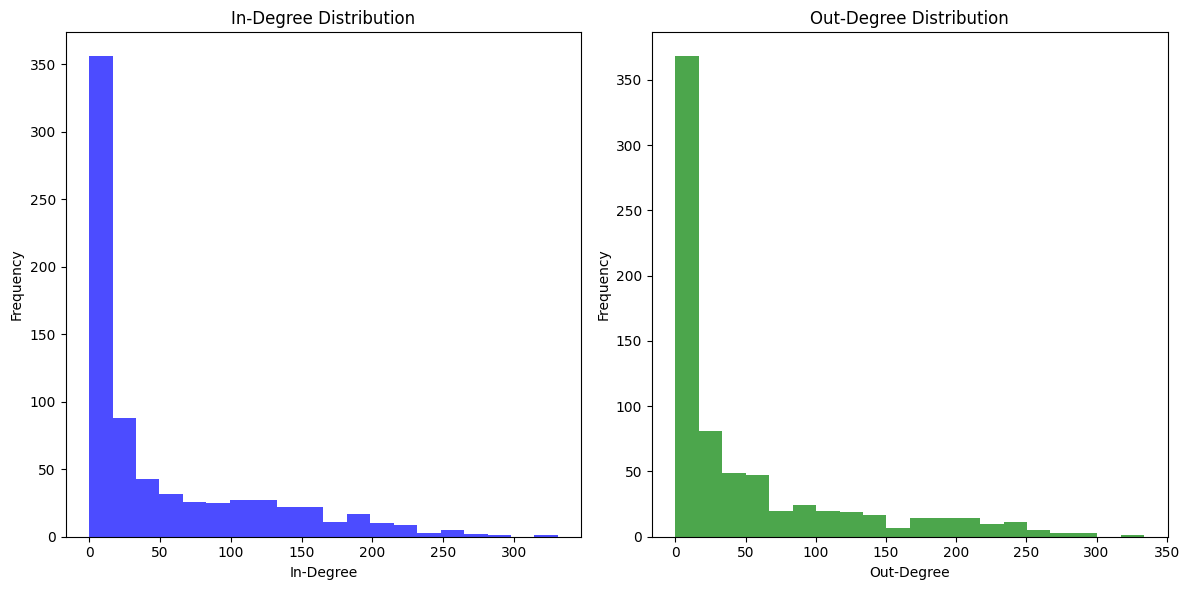

Hubs (airports with degree > 90th percentile): ['SEA', 'PDX', 'SFO', 'LAX', 'FLL', 'PHX', 'TUS', 'DFW', 'SLC', 'RNO', 'ABQ', 'LAS', 'ICT', 'OKC', 'SAN', 'OAK', 'IAH', 'ELP', 'TUL', 'OMA', 'AUS', 'COS', 'MSN', 'RFD', 'MKE', 'DSM', 'LIT', 'SHV', 'MCI', 'SAT', 'MSP', 'ORD', 'STL', 'BNA', 'MEM', 'IND', 'LRD', 'CLE', 'DTW', 'DAY', 'CVG', 'CMH', 'FWA', 'HOU', 'TOL', 'PIT', 'BOS', 'ATL', 'MDW', 'PHL', 'GSO', 'BUF', 'EWR', 'CLT', 'JFK', 'GRR', 'YIP', 'LGA', 'LEX', 'BHM', 'MCO', 'IAD', 'MSY', 'RDU', 'GSP', 'BDL', 'CAE', 'BWI', 'TYS', 'MIA', 'TPA', 'DAL', 'JAX']
The graph is sparse.


In [11]:
analyze_graph_features(G)


1.2

This function generates a detailed **summary report** of the flight network graph, including key features such as:

1. **Number of Nodes and Edges:**  
   - Counts and displays the **total number of airports (nodes)** and **flights (edges)** in the graph.

2. **Graph Density:**  
   - Computes the **density of the graph**, which measures how connected the graph is. The density is calculated using the formula:  
     **Density** = `2 * E / (N * (N - 1))`, where:
     - `E` is the number of edges (flights),
     - `N` is the number of nodes (airports).

3. **Degree Distribution Plots:**  
   - Visualizes the **in-degree** (number of incoming flights) and **out-degree** (number of departing flights) distributions of airports using **histograms**. This helps to understand how airports are connected within the network.

4. **Hubs Identification:**  
   - Identifies the **hubs** in the flight network, which are airports with degrees greater than the **90th percentile** of total degree (sum of in-degree and out-degree).  
   - A table of identified hubs is generated and displayed.



In [11]:
def summarize_graph_features(flight_network):
    # Count the number of nodes (airports) and edges (flights) in the graph
    num_nodes = flight_network.number_of_nodes()
    num_edges = flight_network.number_of_edges()

    # Calculate the graph density (how connected the graph is)
    density = nx.density(flight_network)

    # Calculate in-degree (arriving flights) and out-degree (departing flights) for each airport
    in_degrees = dict(flight_network.in_degree())
    out_degrees = dict(flight_network.out_degree())

    # Create a DataFrame summarizing the degree distribution
    degree_df = pd.DataFrame({
        'Airport': list(in_degrees.keys()),  # List of airport nodes
        'In-Degree': list(in_degrees.values()),  # Number of incoming flights
        'Out-Degree': list(out_degrees.values())  # Number of outgoing flights
    })
    degree_df['Total Degree'] = degree_df['In-Degree'] + degree_df['Out-Degree']  # Total degree for each airport

    # Identify hubs: airports with degree higher than the 90th percentile
    threshold = degree_df['Total Degree'].quantile(0.9)  # Calculate 90th percentile
    hubs_df = degree_df[degree_df['Total Degree'] > threshold].sort_values('Total Degree', ascending=False)  # Sort hubs by total degree

    # Create histograms for degree distribution (in-degree and out-degree)
    plt.figure(figsize=(12, 6))

    # Histogram for In-Degree distribution
    plt.subplot(1, 2, 1)
    plt.hist(degree_df['In-Degree'], bins=20, color='blue', alpha=0.7)
    plt.title('In-Degree Distribution')  # Title for in-degree plot
    plt.xlabel('In-Degree')  # X-axis label
    plt.ylabel('Frequency')  # Y-axis label

    # Histogram for Out-Degree distribution
    plt.subplot(1, 2, 2)
    plt.hist(degree_df['Out-Degree'], bins=20, color='green', alpha=0.7)
    plt.title('Out-Degree Distribution')  # Title for out-degree plot
    plt.xlabel('Out-Degree')  # X-axis label
    plt.ylabel('Frequency')  # Y-axis label

    # Adjust the layout to prevent overlap of plots
    plt.tight_layout()
    plt.show()

    # Create a structured report with the graph's features
    report = {
        'Number of Nodes': num_nodes,  # Number of airports (nodes)
        'Number of Edges': num_edges,  # Number of flights (edges)
        'Graph Density': round(density, 4),  # Graph density rounded to 4 decimal places
        'Degree Distribution Table': degree_df.head(),  # First few rows of the degree distribution table
        'Identified Hubs': hubs_df  # DataFrame of identified hubs (top airports by degree)
    }

    # Print the report
    print("Graph Summary Report:")
    print(f"Number of Nodes: {num_nodes}")
    print(f"Number of Edges: {num_edges}")
    print(f"Graph Density: {density:.4f}")
    print("\nIdentified Hubs (Airports with Top Degrees):")
    display(hubs_df)  # Display the hubs DataFrame in the output

    return report  # Return the summary report as a dictionary


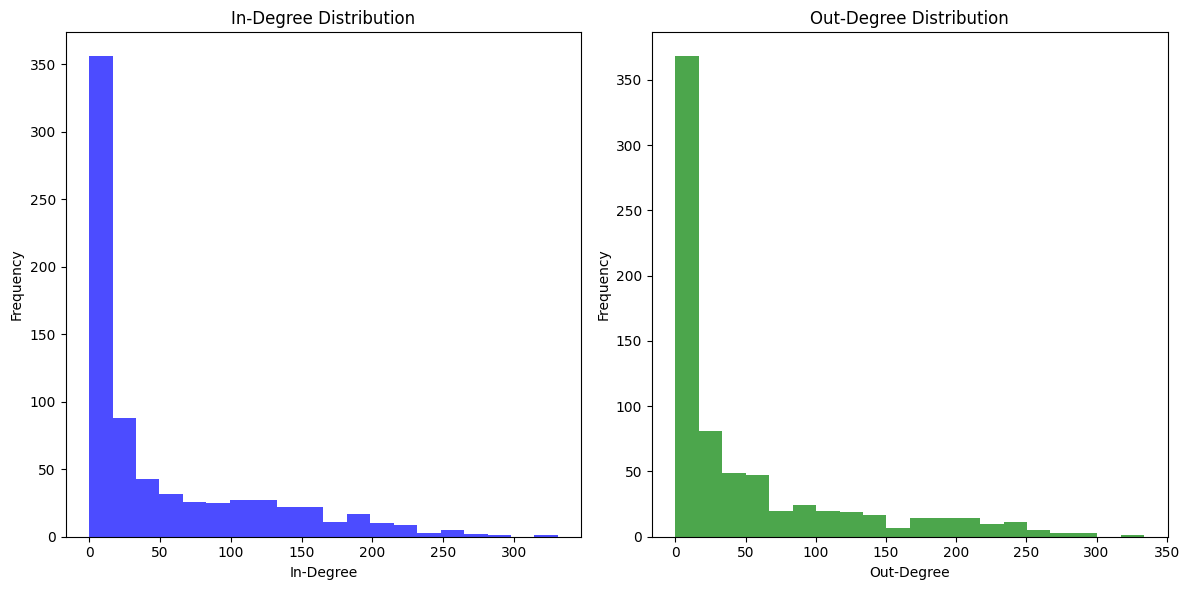

Graph Summary Report:
Number of Nodes: 727
Number of Edges: 36719
Graph Density: 0.0696

Identified Hubs (Airports with Top Degrees):


,Airport,In-Degree,Out-Degree,Total Degree
196,YIP,331,334,665
104,MSP,291,292,583
131,MEM,277,287,564
100,MCI,272,267,539
183,ATL,259,280,539
...,...,...,...,...
198,LGA,146,189,335
151,FWA,165,167,332
195,GRR,152,175,327
304,JAX,146,176,322


{'Number of Nodes': 727,
 'Number of Edges': 36719,
 'Graph Density': 0.0696,
 'Degree Distribution Table':   Airport  In-Degree  Out-Degree  Total Degree
 0     MHK         96          91           187
 1     AMW          1           1             2
 2     EUG         78          83           161
 3     RDM         54          45            99
 4     MFR         52          63           115,
 'Identified Hubs':     Airport  In-Degree  Out-Degree  Total Degree
 196     YIP        331         334           665
 104     MSP        291         292           583
 131     MEM        277         287           564
 100     MCI        272         267           539
 183     ATL        259         280           539
 ..      ...        ...         ...           ...
 198     LGA        146         189           335
 151     FWA        165         167           332
 195     GRR        152         175           327
 304     JAX        146         176           322
 186     GSO        144         175

In [12]:
summarize_graph_features(G)

1.3

This function performs an in-depth analysis of the flight network dataset, focusing on key aspects such as passenger flow, busiest routes, and route utilization.
In particular:
1. **Compute Total Passenger Flow Between Origin and Destination Cities:**  
   - This step aggregates the total number of passengers traveling between each pair of origin and destination cities, helping to identify the most trafficked routes.

2. **Identify and Visualize the Busiest Routes by Passenger Traffic:**  
   - The busiest routes (i.e., those with the highest passenger traffic) are identified and visualized, enabling insights into the primary flight connections in the network.

3. **Calculate the Average Passengers Per Flight for Each Route:**  
   - This step calculates the average number of passengers per flight on each route. It also highlights underutilized routes (with fewer passengers) and overutilized routes (with more passengers than average).

4. **Create an Interactive Map Visualizing the Geographic Spread of the Flight Network:**  
   - The geographic spread of the flight network is visualized using an interactive map, showing the connections between different cities or airports, based on their geographic coordinates.



In [12]:

def compute_passenger_flow(flight_data):
    # Group data by origin and destination cities, summing up the passengers for each route
    passenger_flow = flight_data.groupby(
        ['Origin_city', 'Destination_city']
    )['Passengers'].sum().reset_index()

    # Sort the routes by the total number of passengers in descending order
    passenger_flow = passenger_flow.sort_values('Passengers', ascending=False)

    # Display the top 10 routes with the highest passenger flow
    print("Total Passenger Flow:")
    display(passenger_flow.head(10))

    # Return the DataFrame containing passenger flow for all routes
    return passenger_flow


In [13]:

def visualize_busiest_routes(passenger_flow, top_n=10):
    busiest_routes = passenger_flow.head(top_n)

    plt.figure(figsize=(12, 8))
    plt.barh(
        busiest_routes['Origin_city'] + " → " + busiest_routes['Destination_city'],
        busiest_routes['Passengers'],
        color='skyblue'
    )
    plt.xlabel("Number of Passengers")
    plt.title("Busiest Routes by Passenger Traffic")
    plt.gca().invert_yaxis() # Invert the Y-axis to show the busiest at the top
    plt.show()


In [14]:
def calculate_avg_passengers_per_flight(flight_data):
    # Group the data by origin and destination cities, summing up passengers and flights for each route
    avg_passengers = flight_data.groupby(
        ['Origin_city', 'Destination_city']
    ).agg({'Passengers': 'sum', 'Flights': 'sum'}).reset_index()

    # Calculate the average number of passengers per flight
    avg_passengers['Avg_Passengers_Per_Flight'] = avg_passengers['Passengers'] / avg_passengers['Flights']

    # Identify underutilized and overutilized routes
    underutilized = avg_passengers[avg_passengers['Avg_Passengers_Per_Flight'] < 50]
    overutilized = avg_passengers[avg_passengers['Avg_Passengers_Per_Flight'] > 150]

    # Print the underutilized routes (where passengers per flight < 50)
    print("\nUnderutilized Routes (passengers per flight < 50):")
    display(underutilized.head(10))  # Display top 10 underutilized routes

    # Print the overutilized routes (where passengers per flight > 150)
    print("\nOverutilized Routes (passengers per flight > 150):")
    display(overutilized.head(10))  # Display top 10 overutilized routes

    # Return the average passengers per flight data, underutilized and overutilized routes
    return avg_passengers, underutilized, overutilized


**THE TWO FOLLOWING FUNCTION ARE FOR THE INTERACTIVE MAP, SO WE HAVE TO ADJUST THEM**

In [16]:
'''
import folium

def create_flight_map(flight_data):
    # Crea una mappa centrata sugli Stati Uniti
    flight_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

    # Aggiungi linee tra gli aeroporti
    for _, row in flight_data.iterrows():
        if not pd.isna(row['Org_airport_lat']) and not pd.isna(row['Dest_airport_lat']):
            origin = [row['Org_airport_lat'], row['Org_airport_long']]
            destination = [row['Dest_airport_lat'], row['Dest_airport_long']]
            passengers = row['Passengers']

            # Aggiungi linea alla mappa
            folium.PolyLine(
                [origin, destination],
                color="blue",
                weight=min(passengers / 1000, 5),  # Peso della linea basato sui passeggeri
                tooltip=f"{row['Origin_city']} → {row['Destination_city']} ({passengers} pax)"
            ).add_to(flight_map)

    return flight_map
'''

'\nimport folium\n\ndef create_flight_map(flight_data):\n    # Crea una mappa centrata sugli Stati Uniti\n    flight_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)\n\n    # Aggiungi linee tra gli aeroporti\n    for _, row in flight_data.iterrows():\n        if not pd.isna(row[\'Org_airport_lat\']) and not pd.isna(row[\'Dest_airport_lat\']):\n            origin = [row[\'Org_airport_lat\'], row[\'Org_airport_long\']]\n            destination = [row[\'Dest_airport_lat\'], row[\'Dest_airport_long\']]\n            passengers = row[\'Passengers\']\n\n            # Aggiungi linea alla mappa\n            folium.PolyLine(\n                [origin, destination],\n                color="blue",\n                weight=min(passengers / 1000, 5),  # Peso della linea basato sui passeggeri\n                tooltip=f"{row[\'Origin_city\']} → {row[\'Destination_city\']} ({passengers} pax)"\n            ).add_to(flight_map)\n\n    return flight_map\n'

In [17]:
'''
import folium

# Crea la mappa centrata sugli Stati Uniti
flight_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Crea un gruppo di funzionalità per le rotte più trafficate
feature_group = folium.FeatureGroup(name="Busiest Routes")

# Aggiungi linee alle rotte (solo se le coordinate sono valide)
for _, route in flight_data.iterrows():
    if not pd.isna(route['Org_airport_lat']) and not pd.isna(route['Dest_airport_lat']):
        folium.PolyLine(
            [(route['Org_airport_lat'], route['Org_airport_long']),
             (route['Dest_airport_lat'], route['Dest_airport_long'])],
            color='blue',
            weight=3,
            tooltip=f"{route['Origin_city']} → {route['Destination_city']} | {route['Passengers']} pax"
        ).add_to(feature_group)

# Aggiungi il gruppo alla mappa
feature_group.add_to(flight_map)
folium.LayerControl().add_to(flight_map)

# Visualizza la mappa
flight_map
'''

'\nimport folium\n\n# Crea la mappa centrata sugli Stati Uniti\nflight_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)\n\n# Crea un gruppo di funzionalità per le rotte più trafficate\nfeature_group = folium.FeatureGroup(name="Busiest Routes")\n\n# Aggiungi linee alle rotte (solo se le coordinate sono valide)\nfor _, route in flight_data.iterrows():\n    if not pd.isna(route[\'Org_airport_lat\']) and not pd.isna(route[\'Dest_airport_lat\']):\n        folium.PolyLine(\n            [(route[\'Org_airport_lat\'], route[\'Org_airport_long\']),\n             (route[\'Dest_airport_lat\'], route[\'Dest_airport_long\'])],\n            color=\'blue\',\n            weight=3,\n            tooltip=f"{route[\'Origin_city\']} → {route[\'Destination_city\']} | {route[\'Passengers\']} pax"\n        ).add_to(feature_group)\n\n# Aggiungi il gruppo alla mappa\nfeature_group.add_to(flight_map)\nfolium.LayerControl().add_to(flight_map)\n\n# Visualizza la mappa\nflight_map\n'

In [15]:
# Use a fraction of the dataset (10% in this case) for quicker testing
subset_data = flight_network.sample(frac=0.1)



# Record the start time before running the function
start_time = time.time()

# Execute the function with the subset of data
passenger_flow = compute_passenger_flow(subset_data)

# Record the end time after the function has finished executing
end_time = time.time()

# Print the time taken to process 10% of the dataset
print(f"Time taken for 10% of the dataset: {end_time - start_time:.2f} seconds")


Total Passenger Flow:


,Origin_city,Destination_city,Passengers
3429,"Dallas, TX","Houston, TX",3918925
5818,"Houston, TX","Dallas, TX",3665038
5746,"Honolulu, HI","Kahului, HI",3411998
6394,"Kahului, HI","Honolulu, HI",3129194
7542,"Los Angeles, CA","Honolulu, HI",3114562
9176,"New York, NY","Chicago, IL",3082808
7555,"Los Angeles, CA","Las Vegas, NV",2745970
5749,"Honolulu, HI","Los Angeles, CA",2688516
7132,"Las Vegas, NV","Los Angeles, CA",2657867
7510,"Los Angeles, CA","Chicago, IL",2635794


Time taken for 10% of the dataset: 0.11 seconds


Total Passenger Flow:


,Origin_city,Destination_city,Passengers
7122,"Dallas, TX","Houston, TX",38295025
12391,"Houston, TX","Dallas, TX",37989016
13585,"Kahului, HI","Honolulu, HI",32364664
12259,"Honolulu, HI","Kahului, HI",29744742
16133,"Los Angeles, CA","Honolulu, HI",28964232
12264,"Honolulu, HI","Los Angeles, CA",28632161
16083,"Los Angeles, CA","Chicago, IL",26751937
5323,"Chicago, IL","Los Angeles, CA",26645096
15218,"Las Vegas, NV","Los Angeles, CA",26333721
16152,"Los Angeles, CA","Las Vegas, NV",26177809


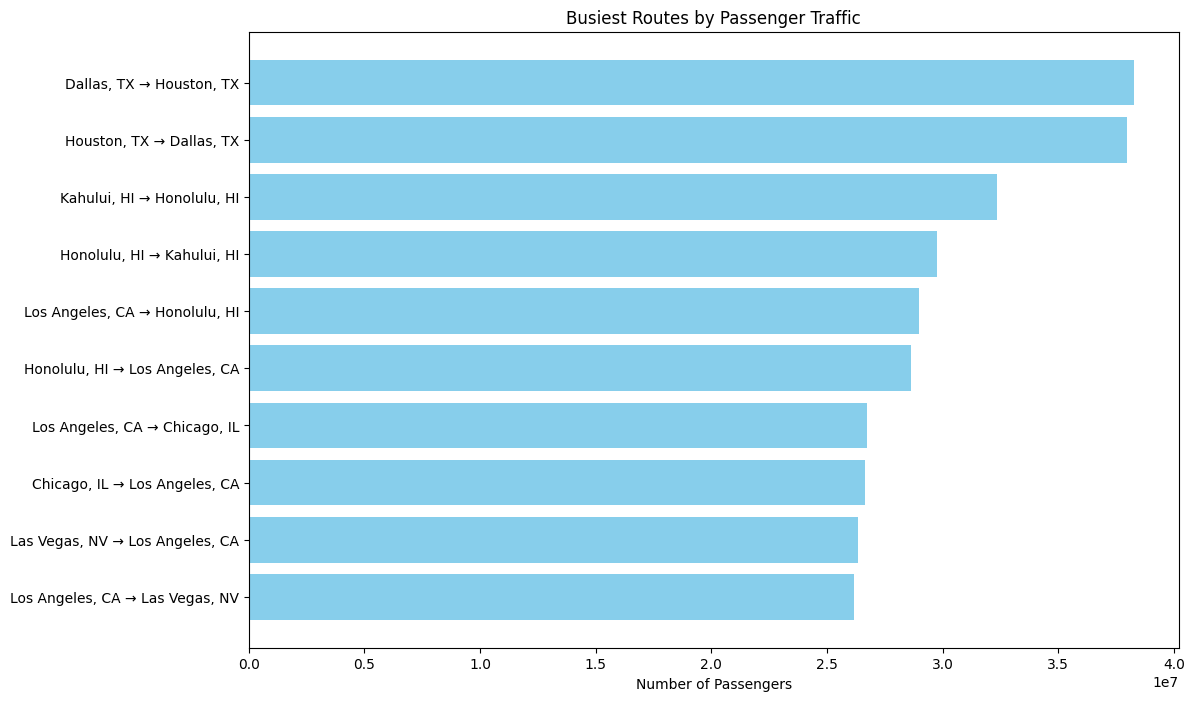


Underutilized Routes (passengers per flight < 50):


,Origin_city,Destination_city,Passengers,Flights,Avg_Passengers_Per_Flight
0,"Aberdeen, SD","Anchorage, AK",2,1,2.000000
2,"Aberdeen, SD","Bismarck, ND",67,2,33.500000
3,"Aberdeen, SD","Brainerd, MN",32,1,32.000000
4,"Aberdeen, SD","Eau Claire, WI",32,1,32.000000
6,"Aberdeen, SD","Grand Forks, ND",0,1,0.000000
7,"Aberdeen, SD","Huron, SD",4869,584,8.337329
8,"Aberdeen, SD","Jamestown, ND",4482,1573,2.849332
9,"Aberdeen, SD","Kansas City, MO",0,1,0.000000
11,"Aberdeen, SD","Mason City, IA",79,4,19.750000
12,"Aberdeen, SD","Minneapolis, MN",344590,16713,20.618082



Overutilized Routes (passengers per flight > 150):


,Origin_city,Destination_city,Passengers,Flights,Avg_Passengers_Per_Flight
23,"Aberdeen, SD","Washington, DC",162,1,162.0
45,"Abilene, TX","Jackson, MS",173,1,173.0
72,"Abilene, TX","Rockford, IL",370,2,185.0
145,"Akron, OH","Jackson, MS",171,1,171.0
149,"Akron, OH","Killeen, TX",153,1,153.0
168,"Akron, OH","Myrtle Beach, SC",160,1,160.0
173,"Akron, OH","Oakland, CA",194,1,194.0
204,"Akron, OH","Tulsa, OK",168,1,168.0
368,"Albany, NY","San Diego, CA",333,2,166.5
400,"Albuquerque, NM","Appleton, WI",166,1,166.0


In [16]:
# Compute the total passenger flow between origin and destination cities
passenger_flow = compute_passenger_flow(flight_network)

# Visualize the busiest routes based on passenger traffic
visualize_busiest_routes(passenger_flow)

# Calculate the average number of passengers per flight for each route
# Also identify underutilized and overutilized routes based on passengers per flight
avg_passengers, underutilized, overutilized = calculate_avg_passengers_per_flight(flight_network)

# Create and visualize the interactive map showing the flight network's geographical spread
#flight_map = create_flight_map(flight_data)

# Display the interactive map
#flight_map


2.1

This function computes four key **centrality measures** for a given airport in the flight network, which help to identify how important or central that airport is within the network. The centrality measures are:

1. **Betweenness Centrality:**  
   - This measure calculates how often a node (airport) appears on the **shortest paths** between other nodes. Airports with high betweenness centrality are **critical connectors** in the network, facilitating the flow between distant nodes.

2. **Closeness Centrality:**  
   - Closeness centrality measures how **easily an airport can reach all other airports** in the network. Airports with high closeness centrality are well-positioned geographically and have good accessibility to other airports.

3. **Degree Centrality:**  
   - Degree centrality simply counts the **number of direct connections** (flights) that an airport has. Airports with high degree centrality are likely to be major hubs, handling a large number of flights.

4. **PageRank:**  
   - PageRank evaluates the **importance** of an airport based on the **incoming flights** and the importance of the airports that provide those flights. This measure considers the "quality" of connections, not just the quantity.

In [17]:
import networkx as nx

def analyze_centrality(flight_network, airport):
    # Check if the airport exists in the graph
    if airport not in flight_network.nodes:
        print(f"Airport '{airport}' not found in the network.")
        return None

    # Calculate centrality measures for the given airport
    centrality_measures = {
        'Betweenness Centrality': nx.betweenness_centrality(flight_network)[airport],
        'Closeness Centrality': nx.closeness_centrality(flight_network)[airport],
        'Degree Centrality': nx.degree_centrality(flight_network)[airport],
        'PageRank': nx.pagerank(flight_network)[airport]
    }

    # Print the results for the given airport
    print(f"Centrality measures for airport {airport}:")
    for measure, value in centrality_measures.items():
        print(f"{measure}: {value:.4f}")

    return centrality_measures  # Return the dictionary of centrality measures for the airport


In [18]:
analyze_centrality(G, "LAS")

Centrality measures for airport LAS:
Betweenness Centrality: 0.0135
Closeness Centrality: 0.5469
Degree Centrality: 0.6529
PageRank: 0.0055


{'Betweenness Centrality': 0.013510110948964864,
 'Closeness Centrality': 0.5469086097588588,
 'Degree Centrality': 0.6528925619834711,
 'PageRank': 0.005549962560197888}

2.2

This function performs a comprehensive comparison of the **centrality measures** for all nodes (airports) in the flight network graph. It computes four key centrality measures for each airport and visualizes their distributions. The steps included in this analysis are:

1. **Compute Centrality Values for All Airports:**  
   - The function computes four centrality measures for each airport in the network:
     - **Betweenness Centrality**
     - **Closeness Centrality**
     - **Degree Centrality**
     - **PageRank**

2. **Visualize Centrality Distributions:**  
   - It creates **histograms** for each of the centrality measures (in-degree, out-degree, betweenness, closeness, and PageRank) to help understand how these values are distributed across the airports in the network.

3. **Identify the Top 5 Airports for Each Centrality Measure:**  
   - The function identifies and returns the **top 5 airports** based on each centrality measure. These airports are the most important in terms of their centrality in the network.

In [19]:


def compare_centralities(flight_network):
    # Calculate centrality measures for all nodes (airports) in the graph
    betweenness = nx.betweenness_centrality(flight_network)
    closeness = nx.closeness_centrality(flight_network)
    degree = nx.degree_centrality(flight_network)
    pagerank = nx.pagerank(flight_network)

    # Create a DataFrame with the centrality measures for each airport
    centrality_df = pd.DataFrame({
        'Airport': list(flight_network.nodes),
        'Betweenness': list(betweenness.values()),
        'Closeness': list(closeness.values()),
        'Degree': list(degree.values()),
        'PageRank': list(pagerank.values())
    })

    # Visualize the distribution of each centrality measure using histograms
    plt.figure(figsize=(16, 10))
    centrality_measures = ['Betweenness', 'Closeness', 'Degree', 'PageRank']

    for idx, measure in enumerate(centrality_measures, 1):
        plt.subplot(2, 2, idx)
        plt.hist(centrality_df[measure], bins=20, color='skyblue', alpha=0.7)
        plt.title(f'{measure} Centrality Distribution')
        plt.xlabel(measure)
        plt.ylabel('Frequency')

    # Adjust the layout to prevent overlap and display the plots
    plt.tight_layout()
    plt.show()

    # Identify the top 5 airports based on each centrality measure
    top_5_results = {}
    for measure in centrality_measures:
        # Get the top 5 airports for the current centrality measure
        top_5 = centrality_df.nlargest(5, measure)[['Airport', measure]]
        top_5_results[measure] = top_5
        print(f"\nTop 5 Airports by {measure} Centrality:")
        display(top_5)

    # Return a dictionary with the top 5 airports for each centrality measure
    return top_5_results


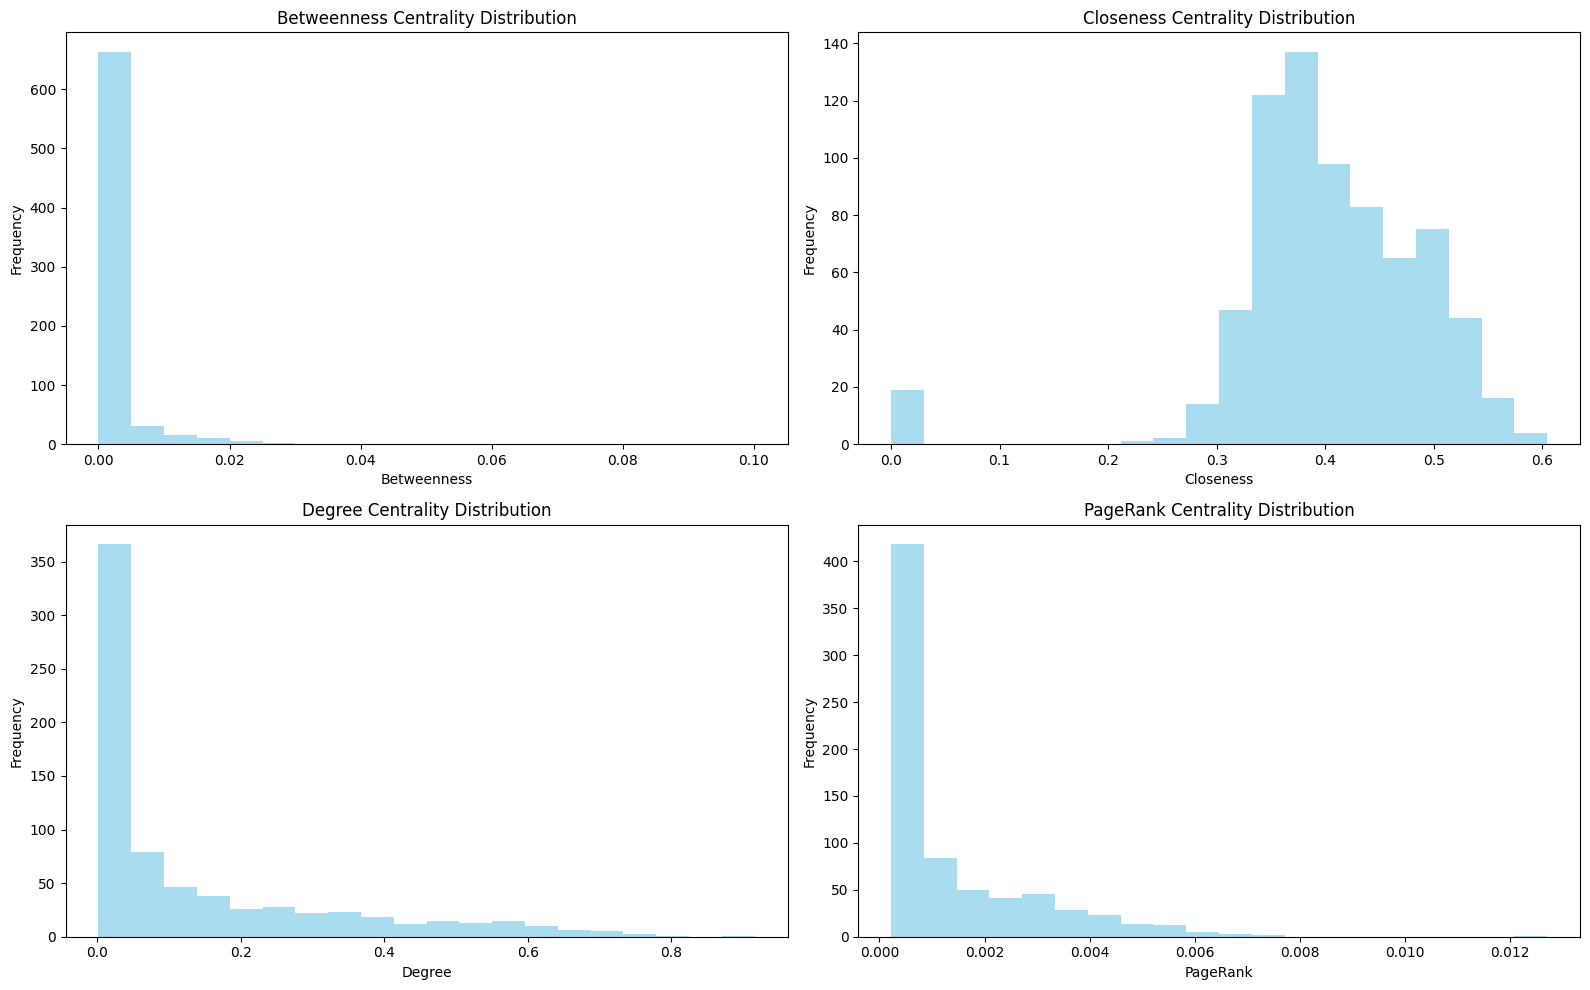


Top 5 Airports by Betweenness Centrality:


,Airport,Betweenness
196,YIP,0.100109
104,MSP,0.027676
131,MEM,0.026827
100,MCI,0.024124
99,SHV,0.022159



Top 5 Airports by Closeness Centrality:


,Airport,Closeness
196,YIP,0.604342
104,MSP,0.587122
131,MEM,0.577567
100,MCI,0.575486
128,STL,0.568824



Top 5 Airports by Degree Centrality:


,Airport,Degree
196,YIP,0.915978
104,MSP,0.803030
131,MEM,0.776860
100,MCI,0.742424
183,ATL,0.742424



Top 5 Airports by PageRank Centrality:


,Airport,PageRank
196,YIP,0.012708
99,SHV,0.007642
104,MSP,0.007559
131,MEM,0.007049
100,MCI,0.007032


{'Betweenness':     Airport  Betweenness
 196     YIP     0.100109
 104     MSP     0.027676
 131     MEM     0.026827
 100     MCI     0.024124
 99      SHV     0.022159,
 'Closeness':     Airport  Closeness
 196     YIP   0.604342
 104     MSP   0.587122
 131     MEM   0.577567
 100     MCI   0.575486
 128     STL   0.568824,
 'Degree':     Airport    Degree
 196     YIP  0.915978
 104     MSP  0.803030
 131     MEM  0.776860
 100     MCI  0.742424
 183     ATL  0.742424,
 'PageRank':     Airport  PageRank
 196     YIP  0.012708
 99      SHV  0.007642
 104     MSP  0.007559
 131     MEM  0.007049
 100     MCI  0.007032}

In [20]:
compare_centralities(G)

2.3

Now we will ask to ChatGPT to suggest us an alternative centrality measures that might be relevant to thi task and we check how the results given by the LLM are trustable.

# **Alternative Centrality Measures Relevant to the Task**

Here are some centrality measures that might be relevant for analyzing the flight network:

## **1. Eigenvector Centrality**
- **Definition:** Measures how connected a node is to other **important nodes**.
- **Why It's Relevant:** In a flight network, it can identify airports that are well-connected **indirectly**, meaning they have important neighboring airports.  
- **Use Case:** Identifying globally important airports like JFK or LHR.

---

## **2. Katz Centrality**
- **Definition:** Similar to eigenvector centrality but considers **connections at all path lengths** and **applies a damping factor**, allowing even less-connected nodes to have some importance.
- **Why It's Relevant:** It highlights **strategic but less busy hubs**.  
- **Use Case:** Identifying smaller, strategically located airports.

---

## **3. Harmonic Centrality**
- **Definition:** A variant of closeness centrality that **works better on disconnected graphs**. It measures how easily a node can access all others, even if the network is not fully connected.
- **Why It's Relevant:** It accounts for **isolated airports** better than standard closeness centrality.  
- **Use Case:** Useful if the flight network has isolated airports or regions.

---

## **4. Clustering Coefficient**
- **Definition:** Measures how **well-connected a node’s neighbors are among themselves**. It indicates whether an airport belongs to a tightly-knit community of airports.
- **Why It's Relevant:** Shows **regional hubs** where many airports have direct flights to each other.  
- **Use Case:** Identifying clusters of airports in a specific region.

---

## **5. Current Flow Betweenness Centrality**
- **Definition:** Measures betweenness using an **electrical network analogy**, considering multiple paths rather than just the shortest ones.
- **Why It's Relevant:** Captures **alternative routes** in a resilient flight network.  
- **Use Case:** Useful for modeling **flight rerouting** in case of airport closures.

---

# **How to Check If the Results Are Trustable**

### **1. Verify Theoretical Sources**  
- Look up definitions and applications in trusted **research papers**, **academic books**, and **online references** such as official documentation from NetworkX, Gephi, or specialized graph theory books.

---

### **2. Test in Practice**  
- **Implement and test the measures** in your graph analysis using libraries like NetworkX in Python.  
- Compare how results differ across various centrality metrics.

---

### **3. Compare with Similar Studies**  
- Find **published studies on flight network analysis** from scientific journals and compare their results with your findings.

---

### **4. Cross-Reference Tool Documentation**  
- Use **official library documentation** like [NetworkX Centrality Documentation](https://networkx.org/documentation/stable/reference/algorithms/centrality.html) to understand precise algorithm implementations.

---

### **5. Peer Feedback**  
- Share your findings with **peers, professors, or online communities** (e.g., Stack Overflow, Reddit, or GitHub) to get critical feedback and ensure validity.


2.4

We implement the eigenvector centrality and we compare the results to the centralities that we have already computed.

In [21]:


def compute_eigenvector_centrality(flight_network):
    # Compute the Eigenvector Centrality for all airports (nodes) in the graph
    eigenvector = nx.eigenvector_centrality(flight_network, max_iter=1000)

    # Create a DataFrame for comparing Eigenvector Centrality values
    centrality_df = pd.DataFrame({
        'Airport': list(flight_network.nodes),  # List of airport nodes
        'Eigenvector Centrality': list(eigenvector.values())  # Eigenvector centrality values
    }).sort_values(by='Eigenvector Centrality', ascending=False)  # Sort the airports by centrality in descending order

    # Visualize the Eigenvector Centrality distribution using a histogram
    plt.figure(figsize=(10, 6))
    plt.hist(centrality_df['Eigenvector Centrality'], bins=20, color='purple', alpha=0.7)
    plt.title('Eigenvector Centrality Distribution')  # Title for the plot
    plt.xlabel('Eigenvector Centrality')  # X-axis label
    plt.ylabel('Frequency')  # Y-axis label
    plt.show()

    # Display the top 5 airports with the highest Eigenvector Centrality
    print("Top 5 Airports by Eigenvector Centrality:")
    display(centrality_df.head(5))  # Show the top 5 rows of the DataFrame

    # Return the DataFrame containing the Eigenvector Centrality values for all airports
    return centrality_df


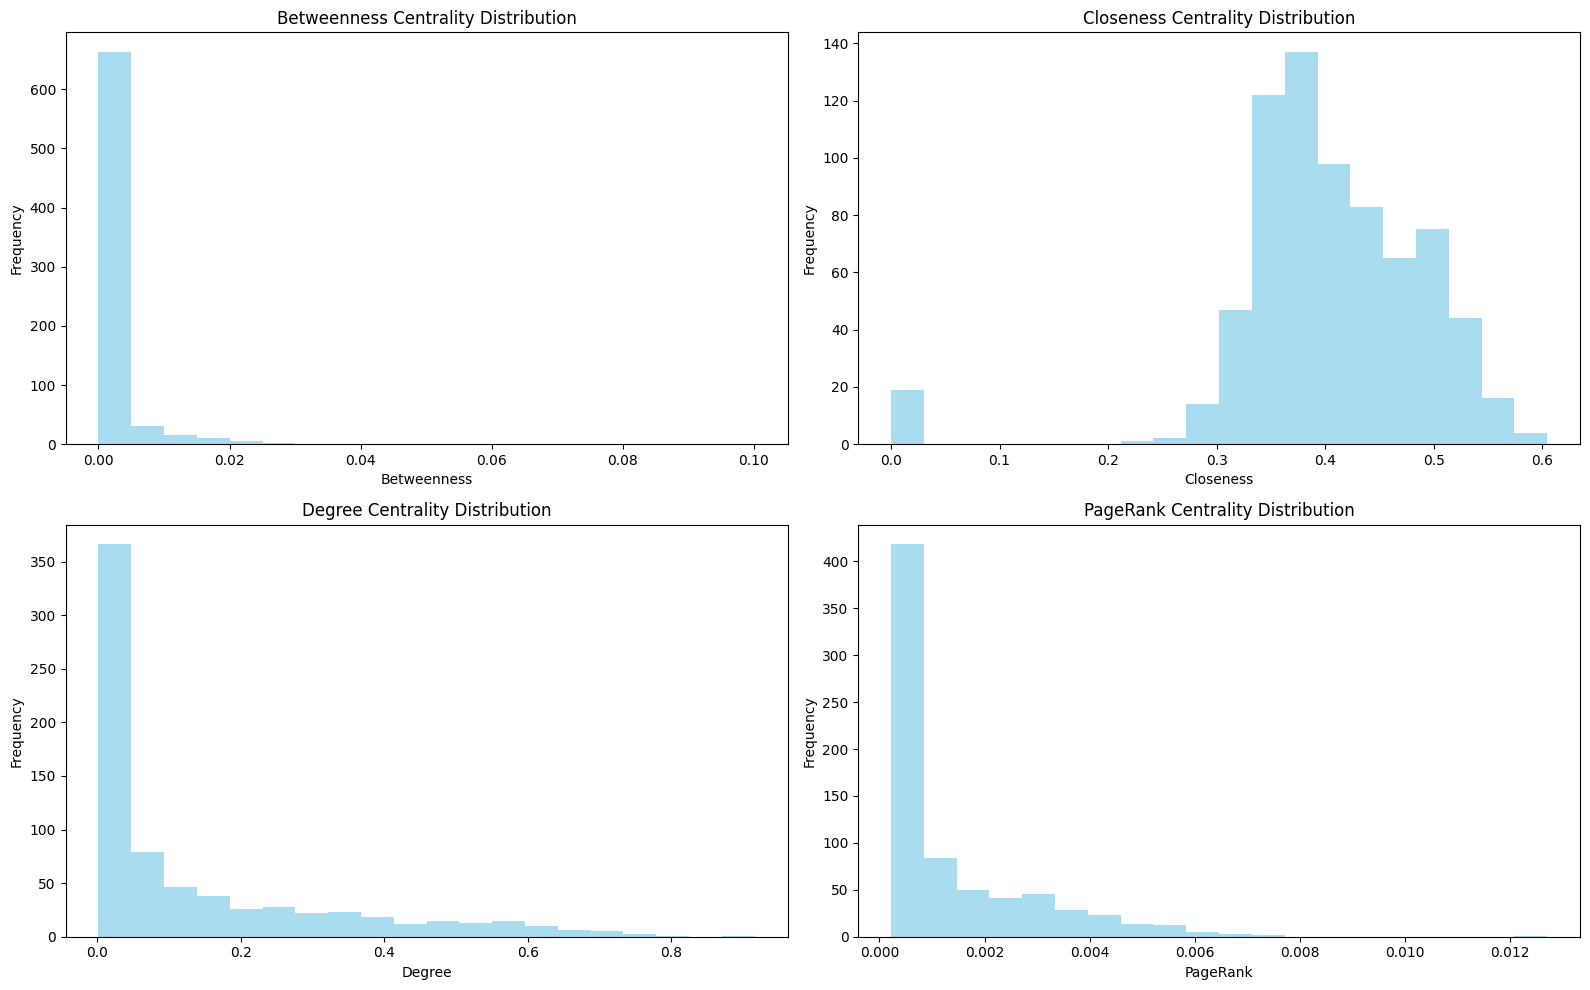


Top 5 Airports by Betweenness Centrality:


,Airport,Betweenness
196,YIP,0.100109
104,MSP,0.027676
131,MEM,0.026827
100,MCI,0.024124
99,SHV,0.022159



Top 5 Airports by Closeness Centrality:


,Airport,Closeness
196,YIP,0.604342
104,MSP,0.587122
131,MEM,0.577567
100,MCI,0.575486
128,STL,0.568824



Top 5 Airports by Degree Centrality:


,Airport,Degree
196,YIP,0.915978
104,MSP,0.803030
131,MEM,0.776860
100,MCI,0.742424
183,ATL,0.742424



Top 5 Airports by PageRank Centrality:


,Airport,PageRank
196,YIP,0.012708
99,SHV,0.007642
104,MSP,0.007559
131,MEM,0.007049
100,MCI,0.007032


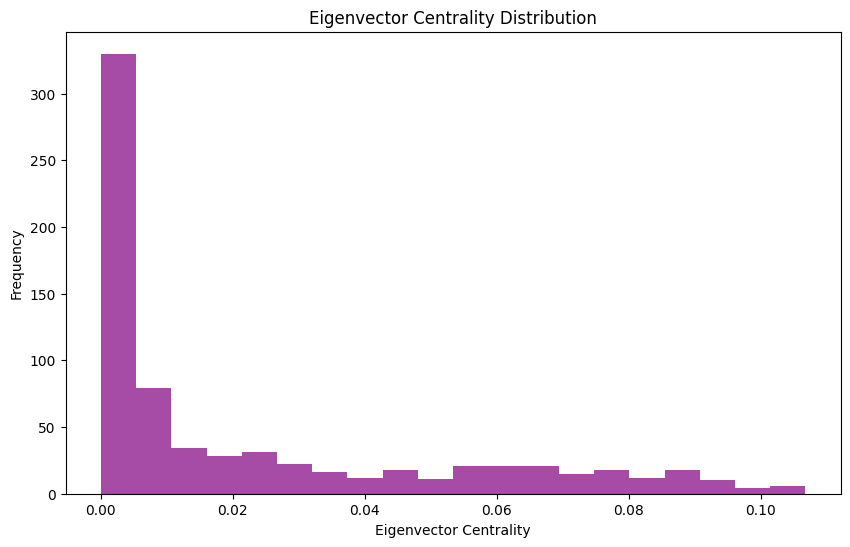

Top 5 Airports by Eigenvector Centrality:


,Airport,Eigenvector Centrality
104,MSP,0.106748
131,MEM,0.105694
136,IND,0.102812
128,STL,0.102692
183,ATL,0.102676


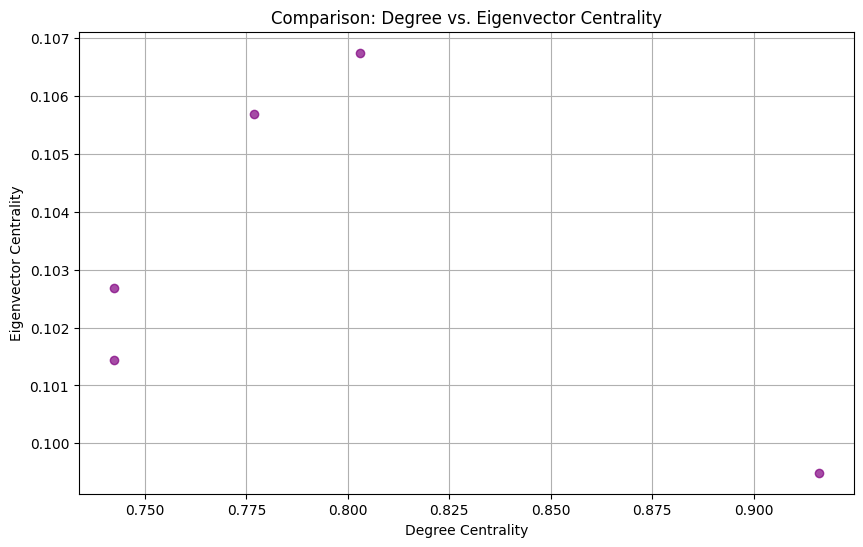

Top 5 Airports by Combined Centrality Measures:


,Airport,Degree Centrality,Eigenvector Centrality
1,MSP,0.803030,0.106748
2,MEM,0.776860,0.105694
4,ATL,0.742424,0.102676
3,MCI,0.742424,0.101431
0,YIP,0.915978,0.099491


In [22]:
# Calculate the centrality measures using the compare_centralities function
centrality_results = compare_centralities(G)

# Calculate the Eigenvector Centrality
eigenvector_df = compute_eigenvector_centrality(G)

# Compare Degree Centrality with Eigenvector Centrality
# Merge the Degree Centrality and Eigenvector Centrality DataFrames on the 'Airport' column
comparison_df = pd.merge(
    centrality_results['Degree'],
    eigenvector_df,
    on='Airport'
).rename(columns={'Degree': 'Degree Centrality'})  # Rename 'Degree' to 'Degree Centrality'

# Visualize the comparison between Degree Centrality and Eigenvector Centrality
plt.figure(figsize=(10, 6))
plt.scatter(comparison_df['Degree Centrality'], comparison_df['Eigenvector Centrality'], color='purple', alpha=0.7)
plt.title('Comparison: Degree vs. Eigenvector Centrality')  # Title of the scatter plot
plt.xlabel('Degree Centrality')  # X-axis label
plt.ylabel('Eigenvector Centrality')  # Y-axis label
plt.grid(True)  # Display grid for better readability
plt.show()

# Display the top 5 airports based on the combined centrality measures (Degree and Eigenvector)
print("Top 5 Airports by Combined Centrality Measures:")
display(comparison_df.nlargest(5, 'Eigenvector Centrality'))  # Display top 5 airports by Eigenvector Centrality


**Comparison of Centrality Measures: Betweenness, Closeness, Degree, PageRank, and Eigenvector Centrality.**

The centrality measures provide a multi-dimensional view of the importance of airports within a flight network. After comparing the top airports by each centrality measure, we can draw several conclusions about how these airports play critical roles in maintaining connectivity, influence, and accessibility across the network.


The **Betweenness centrality** measures how often an airport appears on the shortest paths between other airports. In the results, we observe that YIP leads in betweenness centrality, followed by MSP, MEM, MCI, and SHV. These airports are positioned as key connectors within the network, facilitating the flow of traffic between other regions.

Interestingly, airports like YIP and MSP have high betweenness, meaning that although they may not have the highest number of direct connections, they act as crucial intermediaries in the network. These airports are essential for maintaining connectivity across different parts of the network.

The **Closeness Centrality** indicates how easily an airport can access all other airports in the network. The airports YIP, MSP, MEM, MCI, and STL top the list, with YIP being the most accessible. This suggests that YIP and the other top airports are not just hubs for direct flights but are also centrally located in terms of their ability to connect to other airports with the shortest possible routes.

These airports are well-positioned in the network, ensuring that flights can quickly connect to various destinations, making them strategically valuable.

The **Degree Centrality** simply counts the number of direct connections each airport has, reflecting how busy or active the airport is in terms of flight traffic. In this measure, YIP stands out with the highest degree centrality, followed by MSP, MEM, MCI, and ATL. These airports are the most connected in terms of direct flights.

YIP's top position indicates that it handles a very high volume of direct traffic, making it one of the busiest airports in the network. MSP and ATL are also notable, as their high degree centrality shows they are crucial regional hubs with many incoming and outgoing flights.

The **PageRank Centrality** evaluates an airport's importance based on incoming flights and the significance of the airports providing those flights. The results here show YIP leading by a significant margin, followed by SHV, MSP, MEM, and MCI. This indicates that although YIP has fewer connections than other airports, it is an important node because it is connected to other highly influential airports.

In this context, YIP’s importance comes from its connection to well-ranked airports, making it strategically crucial for the network. Similarly, airports like SHV and MSP are important not only because they have direct traffic but because they are linked to other key airports that amplify their role in the network.

The Eigenvector Centrality, similar to PageRank, considers both the number of connections and the quality of those connections. The top airports here are MSP, MEM, IND, STL, and ATL. MSP tops this list, suggesting it is not only highly connected but also linked to other important airports, making it a global hub in the network.

Airports like MSP and MEM have high eigenvector centrality because they are connected to other influential airports, which reinforces their position in the network. This centrality measure highlights their strategic role in maintaining global connectivity.

6. Combined Centrality Measures
When combining Degree Centrality and Eigenvector Centrality, we get a more holistic view of airport importance. The top airports by these combined measures are MSP, MEM, ATL, MCI, and YIP. This indicates that airports such as MSP and MEM are not just highly connected, but they also play an important strategic role within the network, due to both their high degree and influence.

MSP, MEM, and ATL are the most important nodes, showing both high connectivity and global influence. These airports are pivotal in connecting various regions, with MSP standing out as a major hub with extensive reach and importance.

In conclusion the analysis of centrality measures reveals that YIP, MSP, MEM, MCI, and ATL are the most crucial airports in the network, with MSP and MEM consistently ranking high across multiple measures. YIP stands out due to its significant betweenness and PageRank centrality, making it a key connector despite having fewer connections. ATL's strong degree centrality emphasizes its importance as a regional hub.

In terms of global influence, MSP leads the pack, while airports like YIP and SHV show that even airports with fewer connections can hold great significance in the network, thanks to their connections to other high-ranking airports.

These insights highlight the different ways airports contribute to the network, whether by their direct connections, their strategic positioning, or their influence within the broader network. Combining these centrality measures gives a clearer picture of airport importance and connectivity across the network.








# 3. Finding Best Routes (Q3)

In [26]:
from IPython.display import Image

Image(url='https://media0.giphy.com/media/v1.Y2lkPTc5MGI3NjExcmt6NW1wYXhhdGIwb2c2YjB5Zmh0aXd2N2NtaHY1NHNuZGlhZzZtOSZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/CgUsMkQHFLKoOtQaMD/giphy.webp')

In [24]:
import pandas as pd
from collections import defaultdict
import heapq

def find_best_routes_from_dataset(dataset_path, origin_city, destination_city, date=None):
    # Load dataset
    df = dataset_path
    
    # Columns used: Adjust column names based on your dataset
    df = df[['Origin_airport', 'Destination_airport', 'Origin_city', 'Destination_city', 'Distance']]
    
    # Filter dataset if date column is available
    if date and 'Date' in df.columns:
        df = df[df['Date'] == date]
    
    # Build the graph (adjacency list)
    graph = defaultdict(list)
    airports_by_city = defaultdict(set)

    for _, row in df.iterrows():
        origin_airport = row['Origin_airport']
        destination_airport = row['Destination_airport']
        distance = row['Distance']
        origin_city_name = row['Origin_city']
        destination_city_name = row['Destination_city']

        graph[origin_airport].append((destination_airport, distance))
        airports_by_city[origin_city_name].add(origin_airport)
        airports_by_city[destination_city_name].add(destination_airport)

    # Check if cities exist in the dataset
    if origin_city not in airports_by_city or destination_city not in airports_by_city:
        return "No airports found in one of the cities."

    origin_airports = airports_by_city[origin_city]
    destination_airports = airports_by_city[destination_city]

    # Dijkstra's algorithm
    def dijkstra(graph, start, end):
        pq = [(0, start, [])]  # (distance, current_airport, path)
        visited = set()

        while pq:
            dist, current, path = heapq.heappop(pq)

            if current in visited:
                continue

            visited.add(current)
            path = path + [current]

            if current == end:
                return path

            for neighbor, weight in graph[current]:
                if neighbor not in visited:
                    heapq.heappush(pq, (dist + weight, neighbor, path))

        return None  # No path found

    # Find routes
    results = []

    for origin_airport in origin_airports:
        for destination_airport in destination_airports:
            best_route = dijkstra(graph, origin_airport, destination_airport)
            if best_route:
                results.append({
                    'Origin_city_airport': origin_airport,
                    'Destination_city_airport': destination_airport,
                    'Best_route': ' → '.join(best_route)
                })
            else:
                results.append({
                    'Origin_city_airport': origin_airport,
                    'Destination_city_airport': destination_airport,
                    'Best_route': 'No route found'
                })

    return results


In [26]:
# Example usage
dataset_path = flight_network
origin_city = "Manhattan, KS"  # Replace with a valid city
destination_city = "Bend, OR"  # Replace with a valid city
date = None  # Add date if your dataset includes it

result = find_best_routes_from_dataset(dataset_path, origin_city, destination_city, date)

# Output results
for route in result:
    print(route)

{'Origin_city_airport': 'MHK', 'Destination_city_airport': 'RDM', 'Best_route': 'MHK → EAR → BFF → CPR → RDM'}


# Best Route Algorithm Documentation

#

## Overview

The Best Route Algorithm is designed to determine the most efficient and shortest flight routes between two cities based on the total distance flown. The algorithm processes a dataset containing flight information, including airport codes, cities, and distances, to compute the optimal path between origin and destination airports.

## Key Features

Flexible Input: The algorithm takes a dataset with details about flights, cities, and distances.

Multi-Airport Support: If a city has multiple airports, the algorithm computes the best route for all possible airport pairs.

Shortest Path Calculation: Implements Dijkstra's algorithm to find the shortest path between airports based on distance.

Date Filtering: Supports filtering flights by date if the dataset includes flight schedules.

## Inputs

The algorithm requires the following inputs:

Dataset Path: A CSV file containing flight details.

## Key columns:

Origin: Airport code for the departure location.

Destination: Airport code for the arrival location.

Origin_city: City of the departure airport.

Destination_city: City of the arrival airport.

Distance: Distance between the origin and destination airports.

Date (optional): Flight date (used for filtering).

Origin City: The name of the city where the journey starts.

Destination City: The name of the city where the journey ends.

Date (optional): Specific date to filter flights.

## Algorithm Steps

1. Data Loading and Preprocessing

Load the dataset using pandas.

Extract the relevant columns (Origin, Destination, Origin_city, Destination_city, Distance).

Optionally filter by date if the Date column is present.

2. Build Graph Representation

Construct a graph using an adjacency list where:

Nodes represent airports.

Edges represent flights between airports with weights corresponding to the flight distance.

Group airports by their respective cities to map cities to their airports.

3. Check Input Validity

Verify that both origin and destination cities exist in the dataset.

Extract the list of airports for the origin and destination cities.

4. Compute Shortest Routes

For each pair of origin and destination airports:

Use Dijkstra's algorithm to calculate the shortest path based on distance.

If no path exists, mark it as "No route found."

5. Output Results

Return a table with the following columns:

Origin_city_airport: Airport code for the departure location.

Destination_city_airport: Airport code for the arrival location.

Best_route: A list of airport codes representing the optimal route (e.g., A1 → B1 → C1).

If no route exists, the Best_route column displays "No route found."



# 4. Airline Network Partitioning (Q4)

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

def minimum_cut_disconnection(flight_network):
    """
    Finds the minimum set of flights to remove to disconnect the graph into two subgraphs.

    Args:
        flight_network (list): A list of tuples representing flights (edges) between airports (nodes).

    Returns:
        cut_edges (list): List of flights (edges) to remove.
    """
    # Create a directed graph to treat it as a flow network
    G = nx.DiGraph()
    
    # Add edges with equal capacity of 1 (for an unweighted graph)
    for u, v in flight_network:
        G.add_edge(u, v, capacity=1)
        G.add_edge(v, u, capacity=1)  # For undirected graphs, add the reverse edge

    # Choose arbitrary source and target nodes
    nodes = list(G.nodes)
    if len(nodes) < 2:
        raise ValueError("Graph must have at least two nodes to compute a minimum cut.")

    source = nodes[0]
    target = nodes[1]

    # Find the minimum cut using a flow network algorithm
    cut_value, (set1, set2) = nx.minimum_cut(G, source, target)

    # Extract the cut edges
    cut_edges = [(u, v) for u in set1 for v in set2 if G.has_edge(u, v)]

    return cut_edges, set1, set2

def visualize_graph(G, cut_edges=None, set1=None, set2=None):
    """
    Visualizes the graph and highlights the cut edges and partitions if provided.

    Args:
        G (nx.Graph): The graph to visualize.
        cut_edges (list): The edges to highlight as removed (optional).
        set1 (set): First partition (optional).
        set2 (set): Second partition (optional).
    """
    pos = nx.spring_layout(G)  # Layout for visualization

    # Draw the original graph
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)

    # Highlight cut edges if provided
    if cut_edges:
        nx.draw_networkx_edges(G, pos, edgelist=cut_edges, edge_color='red', width=2)

    # Highlight partitions if provided
    if set1 and set2:
        nx.draw_networkx_nodes(G, pos, nodelist=set1, node_color='green', label="Partition 1")
        nx.draw_networkx_nodes(G, pos, nodelist=set2, node_color='orange', label="Partition 2")

    plt.legend(loc="best")
    plt.show()




Edges to remove to disconnect the graph: [('MHK', 'AMW')]
Partition 1: {'RDD', 'SMF', 'BFI', 'MFR', 'EUG', 'EKO', 'FLL', 'LWS', 'SFO', 'AST', 'GTF', 'TUS', 'MHK', 'EAT', 'FAT', 'DFW', 'SEA', 'BIL', 'LMT', 'PHX', 'PDX', 'PDT', 'CLM', 'PUW', 'RBG', 'RDM', 'SJC', 'ACV', 'LAX', 'SLC', 'MWH', 'GGG', 'SLE', 'GEG', 'YKM'}
Partition 2: {'AMW'}
Original Graph:


C:\Users\Vivo\AppData\Local\Temp\ipykernel_6308\1314541573.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best")


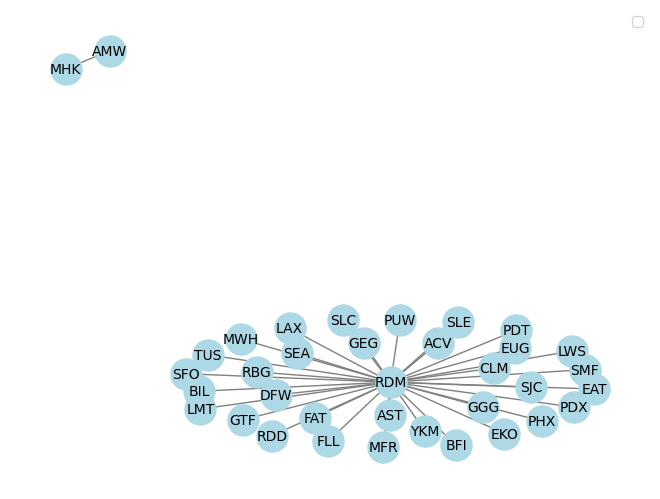

Disconnected Graph:


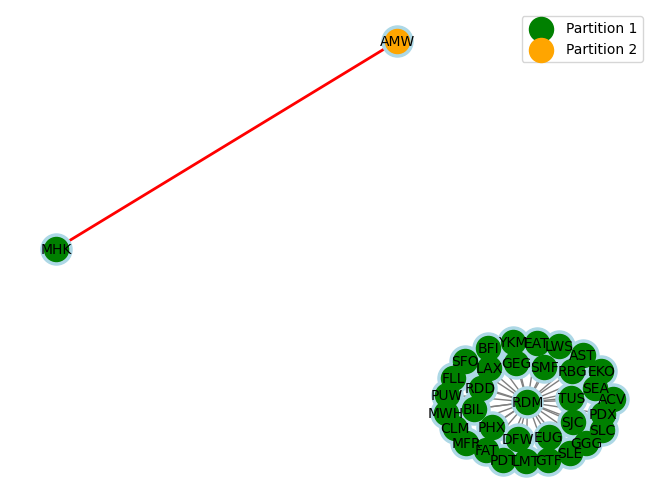

In [33]:
# Example usage
flight_network_try = flight_network[['Origin_airport', 'Destination_airport']].head(1000).values.tolist()

# Find the minimum cut
cut_edges, set1, set2 = minimum_cut_disconnection(flight_network_try)

# Print results
print("Edges to remove to disconnect the graph:", cut_edges)
print("Partition 1:", set1)
print("Partition 2:", set2)

# Visualize the original graph
G = nx.Graph()
G.add_edges_from(flight_network_try)
print("Original Graph:")
visualize_graph(G)

# Visualize the graph after removing cut edges
G.remove_edges_from(cut_edges)
print("Disconnected Graph:")
visualize_graph(G, cut_edges=cut_edges, set1=set1, set2=set2)

# Minimum Cut Disconnection for Flight Networks

This Python script uses the NetworkX library to compute and visualize the minimum cut for an undirected graph representing a network of flights between airports. The minimum cut is the smallest set of edges that, if removed, would disconnect the graph into two disconnected subgraphs.

## Overview of the Code

The script consists of two main parts:

minimum_cut_disconnection: This function computes the minimum cut in the flight network (graph) and returns the edges that need to be removed to disconnect the graph.
visualize_graph: This function visualizes the graph and highlights the cut edges and the two partitions of the graph after the cut.
Functions

### 1. minimum_cut_disconnection(flight_network)

This function performs the following tasks:

Input: A list of tuples representing the edges of the graph. Each tuple represents a flight between two airports (nodes).
Process:
The function creates an undirected graph using NetworkX.
It calculates the minimum cut between two arbitrarily chosen nodes in the graph using nx.minimum_cut().
The function then extracts the edges that are part of the minimum cut.
Output: It returns the following:
cut_edges: A list of edges to be removed in order to disconnect the graph.
set1: The first partition of the graph after the cut.
set2: The second partition of the graph after the cut.

### 2. visualize_graph(G, cut_edges=None, set1=None, set2=None)

This function visualizes the graph and highlights:

The cut edges (edges that disconnect the graph).
The partitions (the two disconnected subgraphs after removing the cut edges).
Input:
G: The graph to visualize.
cut_edges: The edges to highlight as removed (optional).
set1, set2: The two partitions created after the minimum cut (optional).
Process:
The graph is visualized using a spring layout for node positioning.
The original graph is drawn with lightblue nodes and gray edges.
If the cut_edges are provided, they are highlighted in red.
The nodes in set1 are visualized in green, and those in set2 are visualized in orange.


## 5. Finding and Extracting Communities (Q5)

Airlines can optimize their operations by identifying communities within a flight network. These communities represent groups of airports with strong connections, helping airlines pinpoint high-demand regions for expansion or underserved areas for consolidation. By analyzing these communities, airlines can improve resource allocation, reduce costs, and enhance service quality.

### Task Overview

In this task, you are asked to analyze the graph and identify the communities based on the flight network provided. For the airline, the primary focus is on the cities, so your communities should reflect the connectivity between cities through the flights that link them.

### Function Inputs:
1. **Flight network**: The data representing the flight routes between airports.
2. **City name $c_1$**: The first city to check for community membership.
3. **City name $c_2$**: The second city to check for community membership.

### Function Outputs:
1. The total number of communities and the cities that belong to each community.
2. A visualization of the graph highlighting the communities within the network (each community will be represented with a different color).
3. A determination of whether the two cities $c_1$ and $c_2$ belong to the same community or not.


In [34]:

# Load the dataset
#flight_data = pd.read_csv(r"D:\PycharmProjects\adm_hw5\Airports2.csv")

flight_data=flight_network.copy()

In [35]:
flight_data.columns

Index(['Origin_airport', 'Destination_airport', 'Origin_city',
       'Destination_city', 'Passengers', 'Seats', 'Flights', 'Distance',
       'Fly_date', 'Origin_population', 'Destination_population',
       'Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat',
       'Dest_airport_long'],
      dtype='object')

### Function: `find_extract_communities`

This function analyzes a flight network to identify communities of cities that are strongly connected to each other. It uses the `greedy_modularity_communities` method from NetworkX to find these communities. This method is chosen because it efficiently identifies groups of nodes (cities) that are densely connected within themselves but sparsely connected to other groups, making it well-suited for detecting natural clusters in the flight network.

#### Inputs:
- **flight_data**: A table with two columns, `Origin_city` and `Destination_city`, showing flights between cities.
- **city1**: The first city you want to check.
- **city2**: The second city you want to check.

#### Steps:
1. **Clean Data**: Remove any rows where city information is missing.
2. **Create Graph**: Construct a directed graph where cities are nodes, and flights are edges between them.
3. **Find Communities**: Use the `greedy_modularity_communities` method to identify communities based on the structure of the graph. This method finds groups of cities that are tightly connected.
4. **Visualize**: Draw a map of the cities, with each community colored differently.
5. **Report**: Generate a report listing all communities and the cities in each one.
6. **Compare Cities**: Check if the two cities you provided are part of the same community.

#### Output:
- A report that includes:
  - The total number of communities found.
  - A list of cities in each community.
  - Whether the two cities are in the same community.
- A visualization of the flight network with cities grouped and colored by their community.



In [36]:
from networkx.algorithms.community import greedy_modularity_communities

def find_extract_communities(flight_data, city1, city2):
    # Clean the data (remove rows with missing city info)
    clean_data = flight_data.dropna(subset=['Origin_city', 'Destination_city'])
    clean_data['Origin_city'] = clean_data['Origin_city'].astype(str)
    clean_data['Destination_city'] = clean_data['Destination_city'].astype(str)

    # Create a directed graph
    G = nx.DiGraph()
    G.add_edges_from(zip(clean_data['Origin_city'], clean_data['Destination_city']))

    # Remove self-loops (cities that fly to themselves)
    G.remove_edges_from(nx.selfloop_edges(G))

    # Find communities in the network
    communities = list(greedy_modularity_communities(G))

    # Create a mapping of each city to its community
    community_map = {node: idx for idx, community in enumerate(communities) for node in community}

    # Assign random colors to each community
    color_map = {community: (random.random(), random.random(), random.random()) for community in set(community_map.values())}
    node_colors = [color_map[community_map[node]] for node in G.nodes()]

    # Visualize the graph with colors for each community
    plt.figure(figsize=(16, 12))  # Set the size of the plot
    pos = nx.spring_layout(G, seed=42, k=0.8)  # Layout for the nodes (cities)
    nx.draw(
        G, pos,
        with_labels=True,  # Show city names
        node_color=node_colors,  # Use the colors for the communities
        node_size=600,  # Size of the nodes
        font_size=8,  # Font size for labels
        font_weight="bold",  # Bold labels
        edge_color="gray",  # Color of the edges (routes)
        alpha=0.9  # Transparency for better visualization
    )
    #  Prepare the report
    result = f"Community Analysis Report\n\nTotal Number of Communities: {len(communities)}\n\n"
    for idx, community in enumerate(communities):
        result += f"Community {idx + 1}:\n"
        result += f" - Cities: {'; '.join(sorted(community))}\n"  # List cities in each community

    # Check if city1 and city2 are in the same community
    city1_community = community_map.get(city1, None)  # Get community of city1
    city2_community = community_map.get(city2, None)  # Get community of city2

    if city1_community is not None and city2_community is not None:
        if city1_community == city2_community:
            result += f"\n{city1} and {city2} belong to the same community (Community {city1_community + 1}).\n"
        else:
            result += f"\n{city1} and {city2} belong to different communities (Community {city1_community + 1} and Community {city2_community + 1}).\n"
    else:
        result += f"\nOne or both cities ({city1}, {city2}) are not present in the network.\n"

    return result

Community Analysis Report

Total Number of Communities: 5

Community 1:
 - Cities: Albuquerque, NM; Amarillo, TX; Atlanta, GA; Austin, TX; Baltimore, MD; Bangor, ME; Bend, OR; Billings, MT; Bismarck, ND; Boston, MA; Bozeman, MT; Buffalo, NY; Cedar Rapids, IA; Charleston, SC; Charlotte, NC; Chicago, IL; Cincinnati, OH; Cleveland, OH; Colorado Springs, CO; Columbus, OH; Dallas, TX; Des Moines, IA; Durango, CO; El Paso, TX; Eugene, OR; Fairbanks, AK; Fargo, ND; Fayetteville, AR; Fort Lauderdale, FL; Fresno, CA; Grand Junction, CO; Grand Rapids, MI; Great Falls, MT; Houston, TX; Huntsville, AL; Indianapolis, IN; Jackson, WY; Kalispell, MT; Key West, FL; Knoxville, TN; Lincoln, NE; Little Rock, AR; Madison, WI; Medford, OR; Memphis, TN; Miami, FL; Midland, TX; Minneapolis, MN; Minot, ND; Missoula, MT; Nashville, TN; New Orleans, LA; New York, NY; Newark, NJ; Oakland, CA; Oklahoma City, OK; Omaha, NE; Orlando, FL; Peoria, IL; Philadelphia, PA; Portland, OR; Provo, UT; Pueblo, CO; Rapid City,

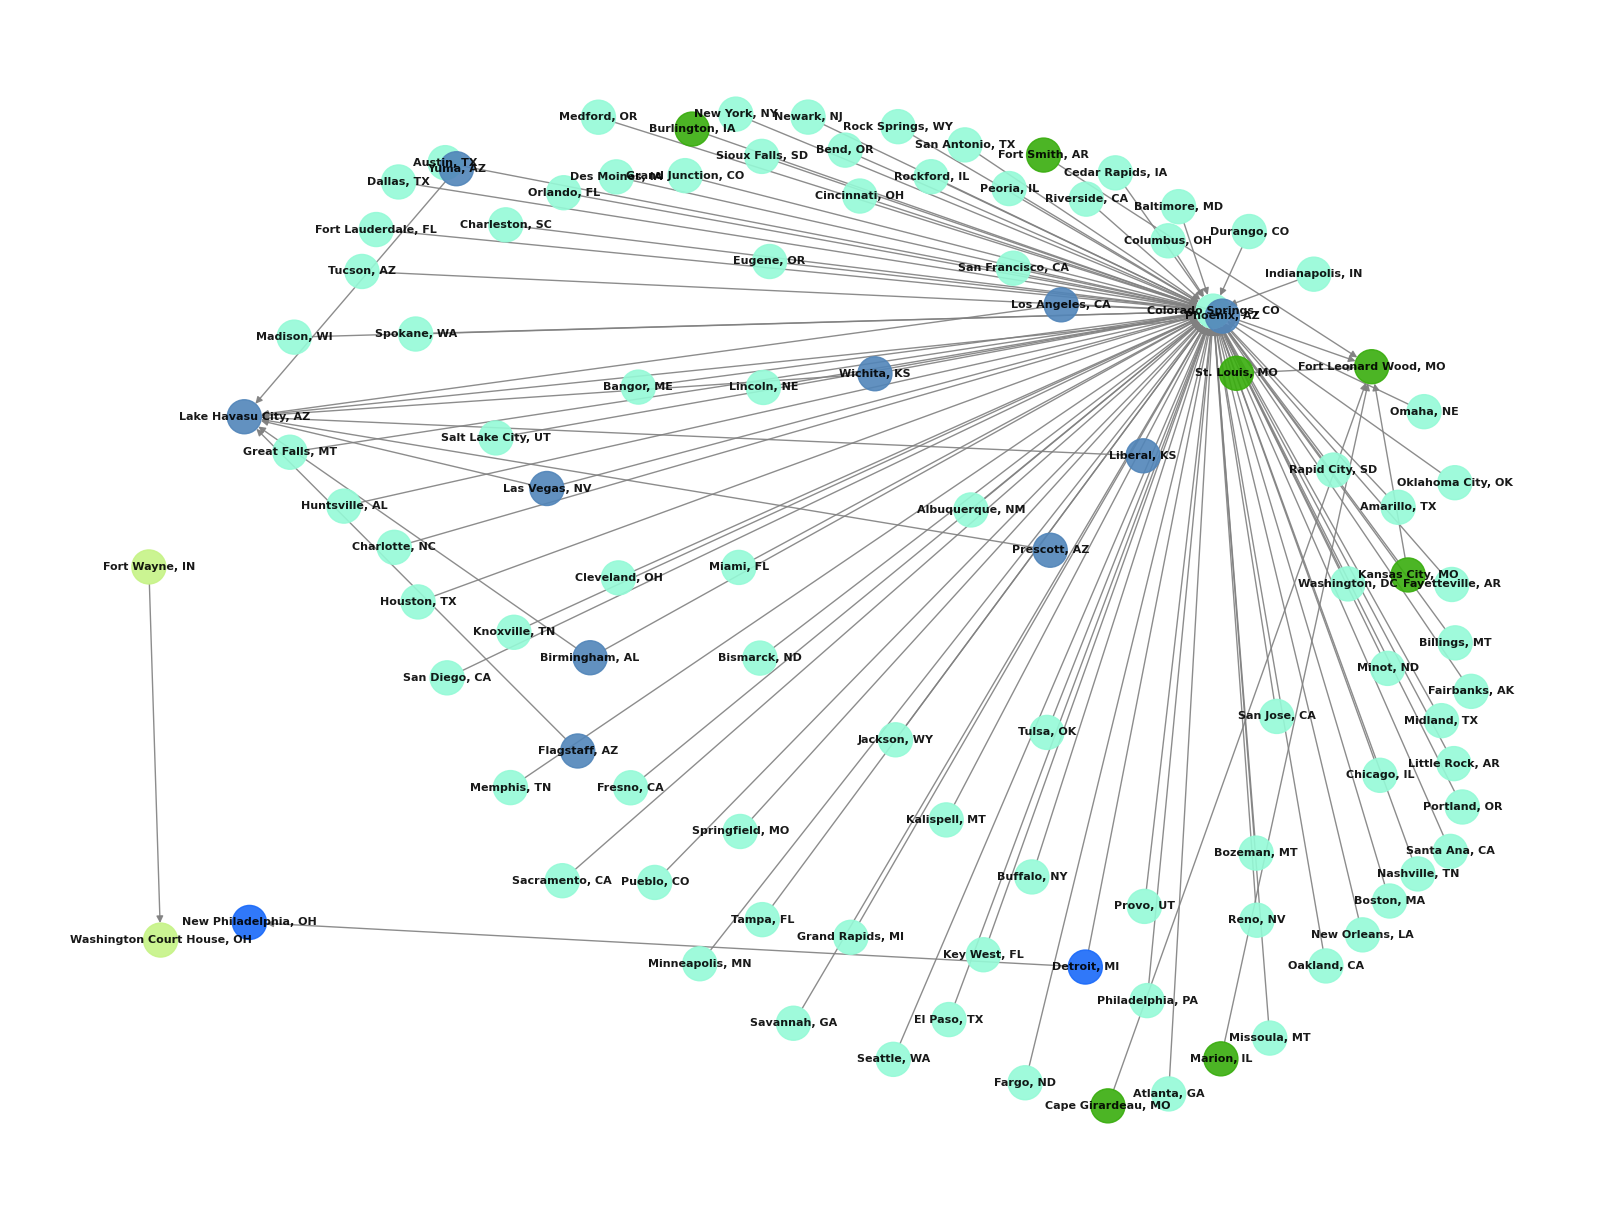

In [37]:

# Sample flight network data
flight_network = flight_data.tail(1000).copy()

# Analyze the flight network
city1 = "Birmingham, AL"
city2 = "Las Vegas, NV"


result = find_extract_communities(flight_network, city1, city2)
print(result)

2. Ask a LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to suggest an alternative algorithm for extracting communities and explain the steps required to implement it. Then, implement this algorithm and compare its results with the current method you've chosen. Discuss the differences in the outcomes and analyze which approach you think is better, providing reasons for your choice.

We applied the Louvain method based on Copilot's suggestion. The Louvain method is an efficient way to detect communities in large networks and is based on optimizing modularity. It's particularly suitable for large graphs due to its speed and scalability.

In [38]:

from networkx.algorithms.community import louvain_communities

def analyze_and_visualize_flight_network_louvain(flight_data, city1, city2):
    """
    Analyze and visualize the flight network graph using the Louvain method, highlighting communities with different colors.

    Parameters:
    flight_data (pd.DataFrame): DataFrame containing 'Origin_city' and 'Destination_city'.

    Returns:
    dict: Results containing community details.
    """
    # Step 1: Clean the data
    clean_flight_data = flight_data.dropna(subset=['Origin_city', 'Destination_city']).copy()
    clean_flight_data['Origin_city'] = clean_flight_data['Origin_city'].astype(str)
    clean_flight_data['Destination_city'] = clean_flight_data['Destination_city'].astype(str)
    clean_flight_data = clean_flight_data[['Origin_city', 'Destination_city']].copy()

    # Step 2: Create a directed graph using 'Origin_city' and 'Destination_city'
    G = nx.Graph()
    G.add_edges_from(zip(clean_flight_data['Origin_city'], clean_flight_data['Destination_city']))

    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))

    # Step 3: Identify communities using Louvain method
    communities = louvain_communities(G, seed=42)
    community_mapping = {node: idx for idx, community in enumerate(communities) for node in community}

    # Step 4: Assign a random color to each community
    unique_communities = set(community_mapping.values())
    color_map = {community: (random.random(), random.random(), random.random()) for community in unique_communities}
    node_colors = [color_map[community_mapping[node]] for node in G.nodes()]

    # Step 5: Visualize the graph
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, seed=42, k=0.8)
    nx.draw(
        G, pos,
        with_labels=True,
        node_color=node_colors,
        node_size=600,
        font_size=8,
        font_weight="bold",
        edge_color="gray",
        alpha=0.9
    )
    plt.title("Flight Network with Highlighted Communities (Louvain Method)")
    plt.show()

    # Step 6: Prepare output
    result = f"Community Analysis Report (Louvain Method)\n\nTotal Number of Communities: {len(communities)}\n\n"
    for idx, community in enumerate(communities):
        result += f"Community {idx + 1}:\n"
        result += f" - Cities: {';'.join(sorted(community))}\n"

    # Check if city1 and city2 belong to the same community
    city1_community = community_mapping.get(city1, None)
    city2_community = community_mapping.get(city2, None)

    if city1_community is not None and city2_community is not None:
        if city1_community == city2_community:
            result += f"\n{city1} and {city2} belong to the same community (Community {city1_community + 1}).\n"
        else:
            result += f"\n{city1} and {city2} belong to different communities (Community {city1_community + 1} and Community {city2_community + 1}).\n"
    else:
        result += f"\nOne or both cities ({city1}, {city2}) are not present in the network.\n"

    return result




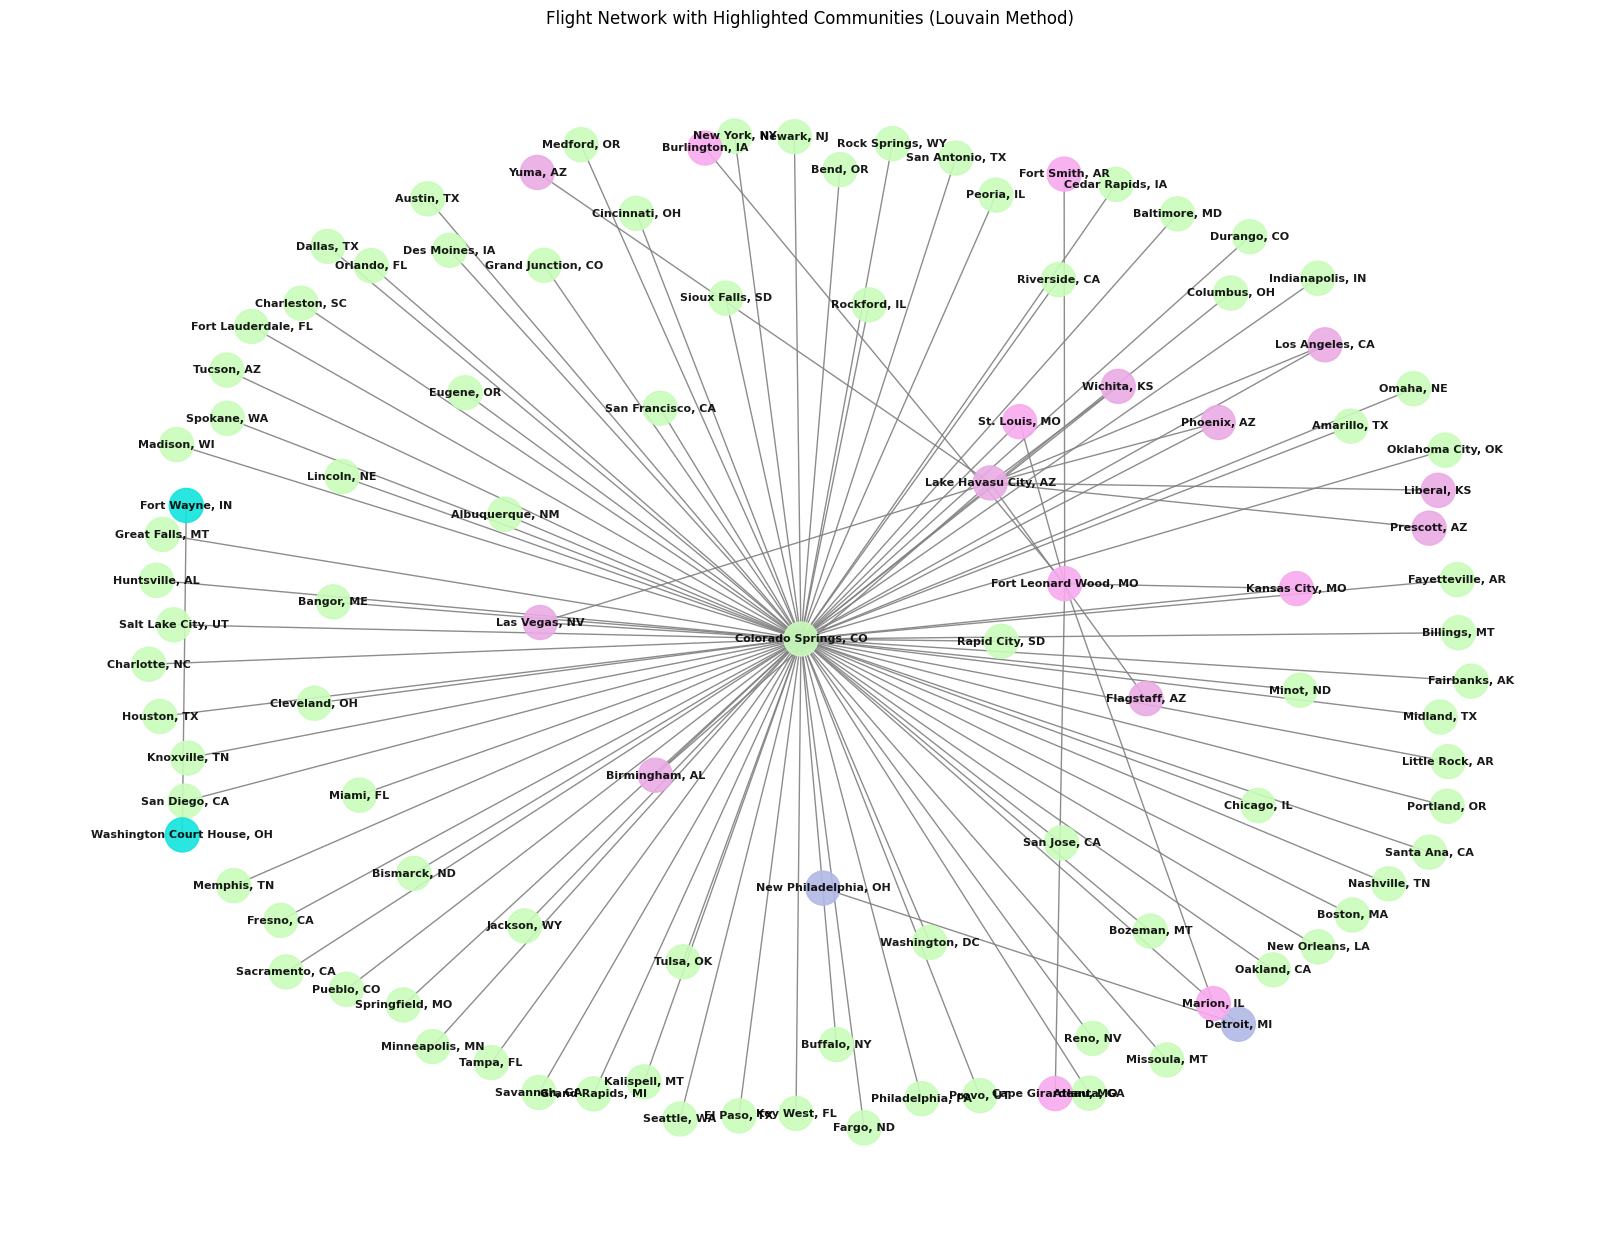

Community Analysis Report (Louvain Method)

Total Number of Communities: 5

Community 1:
 - Cities: Albuquerque, NM;Amarillo, TX;Atlanta, GA;Austin, TX;Baltimore, MD;Bangor, ME;Bend, OR;Billings, MT;Bismarck, ND;Boston, MA;Bozeman, MT;Buffalo, NY;Cedar Rapids, IA;Charleston, SC;Charlotte, NC;Chicago, IL;Cincinnati, OH;Cleveland, OH;Colorado Springs, CO;Columbus, OH;Dallas, TX;Des Moines, IA;Durango, CO;El Paso, TX;Eugene, OR;Fairbanks, AK;Fargo, ND;Fayetteville, AR;Fort Lauderdale, FL;Fresno, CA;Grand Junction, CO;Grand Rapids, MI;Great Falls, MT;Houston, TX;Huntsville, AL;Indianapolis, IN;Jackson, WY;Kalispell, MT;Key West, FL;Knoxville, TN;Lincoln, NE;Little Rock, AR;Madison, WI;Medford, OR;Memphis, TN;Miami, FL;Midland, TX;Minneapolis, MN;Minot, ND;Missoula, MT;Nashville, TN;New Orleans, LA;New York, NY;Newark, NJ;Oakland, CA;Oklahoma City, OK;Omaha, NE;Orlando, FL;Peoria, IL;Philadelphia, PA;Portland, OR;Provo, UT;Pueblo, CO;Rapid City, SD;Reno, NV;Riverside, CA;Rock Springs, WY;Ro

In [39]:
# Sample flight network data
flight_network_test = flight_data.tail(1000).copy()

# Analyze the flight network
city1 = "Birmingham, AL"
city2 = "Las Vegas, NV"



result = analyze_and_visualize_flight_network_louvain(flight_network_test, city1, city2)
print(result)

### Alternative Algorithm for Community Detection

Based on Copilot's suggestion, we initially implemented the **Louvain method** for community detection due to its efficiency and scalability. However, since **Louvain** works with undirected graphs by default, it needs additional modifications to be fully effective on **directed graphs** like flight networks. This led us to use the **greedy_modularity_communities algorithm**, which is better suited for **directed graphs**, as it can take edge directionality into account during community detection.

#### Why These Methods?

- **Louvain Method**: Chosen for its speed and simplicity, making it great for small datasets and undirected graphs. While it can be adapted to directed graphs, it requires more customization.
  
- **Greedy Modularity Communities**: This method is designed specifically for **directed graphs**, making it a better fit for analyzing flight data, where edges (flights) have directionality (from one city to another).

#### Comparison of Results

- **Performance**: The **Louvain method** works quickly and returns results in about 10 seconds on smaller datasets. On larger datasets, the **greedy_modularity_communities algorithm** took around 2 minutes. However, the **greedy_modularity_communities** method is better at capturing community structure in directed networks.

- **Visualization**: For small datasets, the **Louvain method** produced a clearer layout with the densest nodes in the center. The **greedy_modularity_communities algorithm** didn't have the same clear structure but was more accurate for directed data, as it accounts for edge direction.

#### Conclusion

- **For smaller datasets**: The **Louvain method** is faster and easier to understand visually, making it a good choice when speed and visualization are prioritized.
  
- **For larger or directed datasets**: The **greedy_modularity_communities** algorithm is better because it accounts for edge direction in the flight network, providing more accurate results, even though it takes longer than the **Louvain method**.

In summary, **greedy_modularity_communities** is specifically designed for **directed networks**, such as flight data, and provides better community detection in such scenarios, while **Louvain** is faster and simpler.

BONUS